In [205]:
import pandas as pd
import os
from bs4 import BeautifulSoup
from more_itertools import unique_everseen
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage import io
import matplotlib.cm as cm
import cv2
from PIL import Image,ImageEnhance
import random
import scipy.io
from skimage import color

In [2]:
def load_images_from_folder(folder):
    images = []
    filenames = []
    image_list={}
    for filename in os.listdir(folder):
        filenames.append(filename)
        img = io.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)  
        if(filename not in image_list):
            image_list[filename] = []
        image_list[filename].append(img)
    return images,filenames,image_list

def get_mask_data(images,image_list,filenames,bounding_box_dir):
    xml_data =[]
    mask_data={}
    mask_data2={}
    box_data = {}
    for i in range(len(images)):
        file = bounding_box_dir + filenames[i][:-4] + '.xml'
        xml =""
        with open(file) as f:
            xml = f.readlines()
            xml = ''.join([line.strip('\t') for line in xml])
            xml_new  = BeautifulSoup(xml,"lxml")
        xml_data.append(xml_new)
        
    for bd_data in xml_data:
        objs = bd_data.findAll('object')
        fname = bd_data.findChild('filename').contents[0]
        boxes_img = np.copy(np.asarray(img_list[fname])[0,:,:,:])
        for obj in objs:
            obj_names = obj.findChildren('name')
            for name_tag in obj_names:
                
                
                blank_img = np.zeros(np.asarray(img_list[fname])[0,:,:,:].shape)
                bbox = obj.findChildren('bndbox')[0]
                xmin = int(bbox.findChildren('xmin')[0].contents[0])
                ymin = int(bbox.findChildren('ymin')[0].contents[0])
                xmax = int(bbox.findChildren('xmax')[0].contents[0])
                ymax = int(bbox.findChildren('ymax')[0].contents[0])
                blank_img[ymin:ymax,xmin:xmax,:] = 1
                boxes_img = cv2.rectangle(boxes_img,(xmin,ymin),(xmax,ymax),(255,0,0),2)
                if(fname[:-4] not in mask_data):
                    mask_data[fname[:-4]] =[]
                    mask_data2[fname[:-4]] =[]
                    box_data[fname[:-4]] =[]
                mask_data[fname[:-4]].append(blank_img)
                box_data[fname[:-4]]=boxes_img
                mask_data2[fname[:-4]].append([xmin,ymin,xmax,ymax])
                
    return mask_data,mask_data2,box_data


In [101]:
root_dir = 'C:/Users/prath/OneDrive/Documents/IIITH/DIP/Project'
img_dir = os.path.join(root_dir, 'images/')
sample_img_dir = os.path.join(img_dir,'sample_images/')
bounding_box_dir = os.path.join(img_dir,'Bounding_box/')
images,filenames,img_list = load_images_from_folder(sample_img_dir) #list of images with each image with 3d and filenames of each image
mask_data,mask_data2,boxes_data = get_mask_data(images,img_list,filenames,bounding_box_dir) #mask_data - imgs with mask portion white and rest black and mask_data2 array of xmin,ymin,xmax,ymax

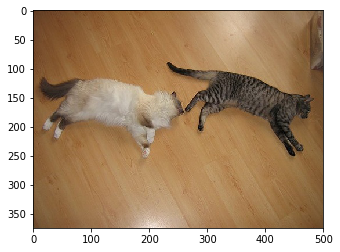

In [231]:
sample_img = np.asarray(img_list['000019.jpg'])[0,:,:,:]
plt.imshow(sample_img)

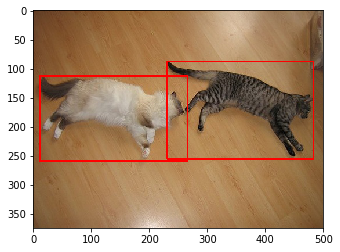

In [232]:
fg = np.asarray(boxes_data['000019'],dtype='uint8')
plt.imshow(fg)

## Generate uniform windows

In [104]:
def generateWindows_uniform(img,params):
    height,width,_ = img.shape
    total_samples = params['distribution_windows']
    min_width = params['min_width']
    min_height = params['min_height']
    xmin = np.zeros((total_samples,1))
    xmax = np.zeros((total_samples,1))
    ymin = np.zeros((total_samples,1))
    ymax = np.zeros((total_samples,1))
    random.seed(100)
    for i in range(0,total_samples):
        x1 = round(random.random()*(width-1)+1)
        x2 = round(random.random()*(width-1)+1)
        while(abs(x1-x2)+1<min_width):
            x1=round(random.random()*(width-1)+1)
            x2=round(random.random()*(width-1)+1)
        
        y1 = round(random.random()*(height-1)+1)
        y2 = round(random.random()*(height-1)+1)
        while(abs(y1-y2)+1<min_height):
            y1=round(random.random()*(height-1)+1)
            y2=round(random.random()*(height-1)+1)
        xmin[i]=min(x1,x2)
        ymin[i]=min(y1,y2)
        xmax[i]=max(x1,x2)
        ymax[i]=max(y1,y2)
#         print('###########')
#         print(x1)
#         print(x2)
#         print(y1)
#         print(y2)
        
#         print('*************')
#         print(xmin[i])
#         print(ymin[i])
#         print(xmax[i])
#         print(ymax[i])
        
    windows = [xmin,ymin,xmax,ymax]
    return np.asarray(windows)
        

In [139]:
windows = generateWindows_uniform(sample_img,params)

In [140]:
windows[2][0]

array([228.])

In [141]:
np.asarray(windows)[0]

array([[ 74.],
       [217.],
       [ 41.],
       ...,
       [118.],
       [211.],
       [ 48.]])

## Generate dense windows

In [142]:
def generateWindows_dense(img,params):
    pixelDistance = params['pixelDistance']
    imageBorder = params['imageBorder']
    height,width,_ = img.shape

    offsetHeight = np.floor(imageBorder * height)
    offsetWidth  = np.floor(imageBorder * width)

    height = int(np.floor(height * (1 - imageBorder)/pixelDistance))
    width  = int(np.floor(width  * (1 - imageBorder)/pixelDistance))

    totalWindows = int(height*width * (height+1) * (width+1)/4)
    
    xmin = np.zeros((totalWindows,1))
    xmax = np.zeros((totalWindows,1))
    ymin = np.zeros((totalWindows,1))
    ymax = np.zeros((totalWindows,1))

    currentWindow = 0

    for x in range(0,width):
        for y in range(0,height):
            for w in range(0,width - x ):
                for h in range(0,height - y):
                    
                    xmin[currentWindow] = x
                    ymin[currentWindow] = y
                    xmax[currentWindow] = x + w - 1
                    ymax[currentWindow] = y + h - 1
                    currentWindow = currentWindow+1
                
    xmin = xmin * pixelDistance + offsetWidth
    xmax = xmax * pixelDistance + offsetWidth
    ymin = ymin * pixelDistance + offsetHeight
    ymax = ymax * pixelDistance + offsetHeight

    windows = [xmin,ymin,xmax,ymax]
    return np.asarray(windows)

## Compute Area of a given box

In [196]:
def computeArea(box):
    
    xmin = box[0]
    ymin = box[1]
    xmax = box[2]
    ymax = box[3]
    if(xmin>xmax or ymin>ymax):
        area = 0
    else:
        area = (xmax-xmin+1)*(ymax-ymin+1)
    return area

## Compute area of intersectin for two boxes/windows

In [194]:
def computeIntersectionArea(box1,box2):
    xmin = max(box1[0],box2[0])
    ymin = max(box1[1],box2[1])
    xmax = max(box1[2],box2[2])
    ymax = max(box1[3],box2[3]) 
    intersection_box = np.asarray([xmin,ymin,xmax,ymax]).reshape((4,1))
    intersection_area = computeArea(intersection_box)
    return intersection_area

### Pascal Score

In [145]:
def computePascalScore(box1,box2):
    intersection_area = computeIntersectionArea(box1,box2)
    pascalScore = intersection_area/(computeArea(box1)+computeArea(box2)-intersection_area)
    return pascalScore

## NMS sampling

In [249]:
def nms_sample(boxes,threshold,maxWindows):
    xmin = boxes[0][0]
    ymin = boxes[0][1]
    xmax = boxes[0][2]
    ymax = boxes[0][3] 
    scores = (boxes[1]).reshape(50000,)
    area = (xmax-xmin+1) * (ymax-ymin+1)
    #print(scores.shape)
    indices = np.argsort(scores)
    #print(indices)
    #print('*****')
    pick=[]
    s_list=[]
    while(len(indices)>0):
        last = len(indices)-1
        i = indices[last]
        
        pick.append(i)
        #print(i)
        supress = [last]
        s_list.append(last)
        for pos in range(0,last):
            j = indices[pos]
            
            xx1 = max(xmin[i],xmin[j])
            yy1 = max(ymin[i],ymin[j])
            xx2 = min(xmax[i],xmax[j])
            yy2 = min(ymax[i],ymax[j])
            
            w = max(0,xx2-xx1+1)
            h = max(0,yy2-yy1+1)
            b1 = [xmin[i],ymin[i],xmax[i],ymax[i]]
            b2 = [xmin[j],ymin[j],xmax[j],ymax[j]]
            overlap = computePascalScore(b1,b2)
            #overlap = float(w*h)/area[j]
            #print(overlap)
            if(overlap>=threshold):
                supress.append(pos)
                s_list.append(pos)
        indices = np.delete(indices,supress)
    #print((pick))
    xmin_final=xmin[pick]
    ymin_final=ymin[pick]
    xmax_final=xmax[pick]
    ymax_final=ymax[pick]
    
    boxes_final = [xmin_final,ymin_final,xmax_final,ymax_final]
    return np.asarray(boxes_final),pick,scores
    
    

In [147]:
def runObjectness(img,params,maxWindows=10):
    windows = generateWindows_uniform(img,params)
    theta = params['CC']['theta']
    distributionBoxes = computeScores(img,params,'CC',windows,theta)
    #boxes = nms_sample(distributionBoxes,0.5,maxWindows)
    return distributionBoxes

In [148]:
def drawboxes(img,boxes):
    print(boxes.shape)
    xmin = (boxes[0,:])
    ymin = (boxes[1,:])
    xmax = (boxes[2,:])
    ymax = (boxes[3,:])
    box_img = np.copy(img)
    for i in range(0,len(xmin)):
        box_img = cv2.rectangle(box_img,(int(xmin[i]),int(ymin[i])),(int(xmax[i]),int(ymax[i])),[255,0,0],2)
    return box_img
        

In [149]:
def demo(img):
    boxes = runObjectness(img,params,10)
    #box_img = drawboxes(img,boxes)
    return boxes

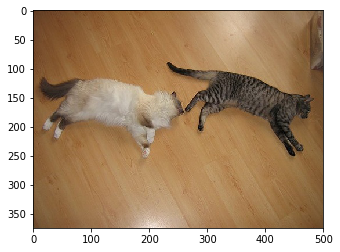

In [233]:
plt.imshow(sample_img)

## Positive negative images

In [151]:
def generatePosNeg(params):
    root_dir = 'C:/Users/prath/OneDrive/Documents/IIITH/DIP/Project'
    img_dir = os.path.join(root_dir, 'images/')
    sample_img_dir = os.path.join(img_dir,'sample_images/')
    bounding_box_dir = os.path.join(img_dir,'Bounding_box/')
    images,filenames,img_list = load_images_from_folder(sample_img_dir) #list of images with each image with 3d and filenames of each image
    mask_data,mask_data2,boxes_data = get_mask_data(images,img_list,filenames,bounding_box_dir) #mask_data - imgs with mask portion white and rest black and mask_data2 array of xmin,ymin,xmax,ymax
    posneg = []
    
    for i in range(0,len(mask_data2)):
        image = plt.imread(sample_img_dir+filenames[i])
        windows = generateWindows_uniform(image,params)
        windows_num,_ = windows.shape
        posneg[i].append({'examples': windows})
        labels = -1*np.ones((windows_num,1))
        for w in range(0,windows_num):
            for b in range(0,len(mask_data2[filenames[i][:-4]])):
                pascalScore = computePascalScore(mask_data2[filenames[i][:-4]][b], windows[w])
                if(pascalScore>params['pascalThreshold']):
                    labels[w] = 1
                    break
        
        posneg[i].append({'labels': labels})
        posneg[i].append({'img': image})
    return posneg
    

In [152]:
def computeQuantMatrix(imgLAB,bins):
    L = imgLAB[:,:,0]
    a = imgLAB[:,:,1]
    b = imgLAB[:,:,2]
    
    ll = np.minimum(np.floor(L/(100/bins[0])) + 1,bins[0])
    
    aa = np.minimum(np.floor((a+120)/(240/bins[1])) + 1,bins[1])
    bb = np.minimum(np.floor((b+120)/(240/bins[2])) + 1,bins[2])

    Q = (ll-1)* bins[1]*bins[2] + (aa - 1)*bins[2] + bb
    return np.asarray(Q,dtype='uint8')

## CC score

In [428]:
def computeContrastScore(Q,windows,theta):
    
    height,width= Q.shape
    surrBox = np.copy(windows)
    contrast = np.zeros(((windows.shape[1]),1))
    Q2 = np.copy(Q)
    for w in range(0,windows.shape[1]):
        xmin = int(windows[0][w])
        ymin = int(windows[1][w])
        xmax = int(windows[2][w])
        ymax = int(windows[3][w])
        
        num_pixels_inner = abs((xmin-xmax+1)*(ymin-ymax+1))
        
        mask_inner = np.zeros((height,width),dtype='uint8')
        mask_inner[ymin:ymax, xmin:xmax]= 255
        
        
        #plt.imshow(mask_inner)
        H_inner = cv2.calcHist([Q],[0],mask_inner,histSize=[256],ranges=[0,256])
        
        offsetWidth=width*theta/200;
        offsetHeight=height*theta/200;

        xminSurr=round(max(xmin-offsetWidth,0))
        xmaxSurr=round(min(xmax+offsetWidth,width))
        yminSurr=round(max(ymin-offsetHeight,0))
        ymaxSurr=round(min(ymax+offsetHeight,height))
        
        a = Q[yminSurr:ymaxSurr,xminSurr:xmin].flatten()
        b = Q[yminSurr:ymaxSurr,xmax:xmaxSurr].flatten()
        c = Q[yminSurr:ymin,xmin:xmax].flatten()
        d = Q[ymax:ymaxSurr,xmin:xmax].flatten()
        
        outer_r = np.hstack((a,b,c,d))
        
        
        num_pixels_outer = len(outer_r)
        
#         mask_outer = np.zeros((height,width),dtype='uint8')
#         mask_outer[yminSurr:ymaxSurr, xminSurr:xmaxSurr]= 255
        
        H_outer = cv2.calcHist([outer_r],[0],None,histSize=[256],ranges=[0,256])
        
        H_inner2 = np.asarray(H_inner/num_pixels_inner,dtype='float32')
        H_outer2 = np.asarray(H_outer/num_pixels_outer,dtype='float32')
        
        Q2 = cv2.rectangle(Q2,(xminSurr,yminSurr),(xmaxSurr,ymaxSurr),(0,255,0),2)
        Q2 = cv2.rectangle(Q2,(xmin,ymin),(xmax,ymax),(255,0,0),2)
        
        contrast[w] = cv2.compareHist(H_inner2, H_outer2, 1)
        
    
       
    #plt.imshow(Q2)    
    return contrast     
        
        
        

In [ ]:
# def compareHistograms(H1,H2):
    

In [154]:
def computeScores(image,params,cue,windows,theta):
    height, width, _ = image.shape
    totalWindows = len(windows)
    imgLab = color.rgb2lab(image)
    quant = params[cue]['quant']
    Q = computeQuantMatrix(imgLab,quant)
    score = computeContrastScore(Q,windows,theta)
    
    boxes = [windows,score]
    return np.asarray(boxes)
    
    
    

## Log likelihood

In [155]:
def deriveLogLikelihood(posneg,theta,params,cue):
    params[cue]['theta'] = theta
    examplePos = np.zeros((len(posneg)*params['distribution_windows'],1))
    exampleNeg = np.zeros((len(posneg)*params['distribution_windows'],1))
    pos = 0
    neg = 0
    for i in range(0,len(posneg)):
        temp = computeScores(posneg[i]['img'],params,'CC',posneg[i]['examples'],theta);
        posneg[i]['scores'] = temp[:,-1]
        indexPositive = np.argwhere(posneg[i]['labels'] == 1)
        examplesPos[pos:pos+len(indexPositive)] = posneg[i]['scores'][indexPositive]
        pos = pos + len(indexPositive)

        indexNegative = np.argwhere(posneg[i]['labels'] == -1)
        examplesNeg[neg:neg+len(indexNegative)] = posneg[i]['scores'][indexNegative]
        neg = neg + len(indexNegative)
        
    examplePos = examplePos[:pos+1]
    exampleNeg = exampleNeg[:,neg+1]
    
    pobj = (pos)/(pos+neg)
    pbg = 1- pobj
    
    
        
        
        
        

In [417]:
params={}
params['distribution_windows']=50000
params['min_width']=10
params['min_height']=10
params['pixelDistance']=8
params['imageBorder']=0.05
params['pascalThreshold'] = 0.5
params['CC'] = {}
params['CC']['domain'] = list(range(100,201,1))
params['CC']['quant'] = np.array([4,8,8])
params['CC']['theta'] = 8


In [418]:
i=ImageEnhance.Contrast(Image.fromarray(sample_img))

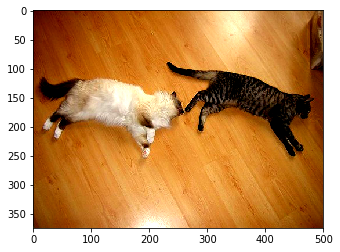

In [419]:
sample_img2 = np.asarray(i.enhance(2))
plt.imshow(sample_img2)

In [420]:
eye = plt.imread("images/sample_images/OrigImg0013.bmp")

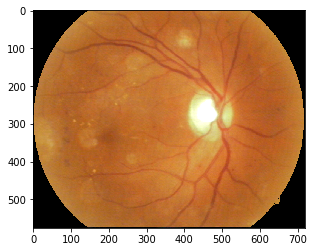

In [421]:
plt.imshow(eye)

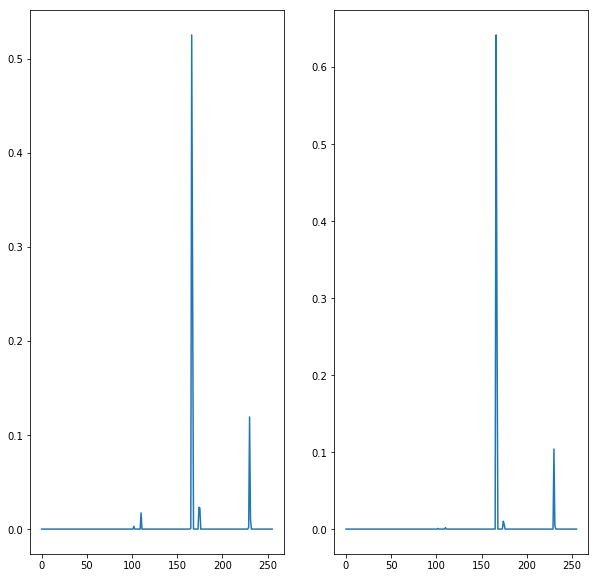

In [430]:
boxes = demo(sample_img2)

In [423]:
boxes_f,i,s = nms_sample(boxes,0.1,10)

In [424]:
i

[8749, 10896, 21127, 31651]

In [425]:
b3 = [100,170,180,200]
b4 = [120,180,160,190]

In [426]:
box_img = drawboxes(eye,boxes_f)

(4, 4, 1)


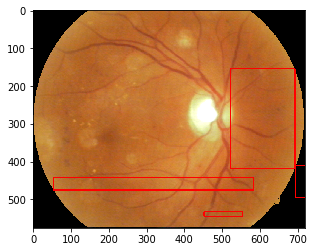

In [427]:
plt.imshow(box_img)

In [378]:
imgLab = color.rgb2lab(eye)
Q = computeQuantMatrix(imgLab,[4,8,8])

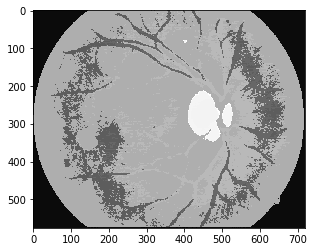

In [379]:
plt.imshow(Q,cmap='gray')

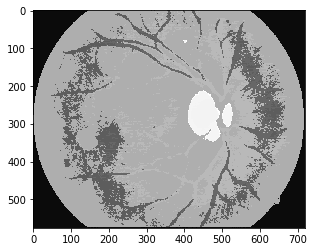

In [380]:
plt.imshow(Q,cmap='gray')

In [382]:
x=np.array([3,5,6,2,6,3],dtype='uint8')
h = cv2.calcHist([x],[0],None,[10],ranges=[1,10])

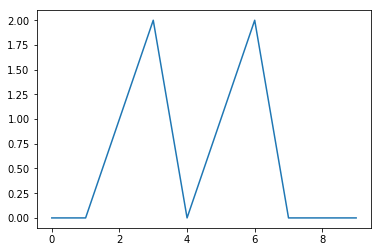

In [384]:
plt.plot(h)

In [385]:
Q

array([[37, 37, 37, ..., 37, 37, 37],
       [37, 37, 37, ..., 37, 37, 37],
       [37, 37, 37, ..., 37, 37, 37],
       ...,
       [37, 37, 37, ..., 37, 37, 37],
       [37, 37, 37, ..., 37, 37, 37],
       [37, 37, 37, ..., 37, 37, 37]], dtype=uint8)

In [390]:
b2 = [100,170,180,200]
b1 = [120,180,160,190]

In [391]:
a = Q[170:200,100:120].flatten()

In [393]:
b = Q[170:200,160:180].flatten()

In [394]:
c = Q[170:180,120:160].flatten()
d = Q[190:200,120:160].flatten()

In [400]:
arr = np.hstack((a,b,c,d))

In [402]:
len(arr)

2000